# Análise Risco de Alagamento - Município de Pernambuco

## Importar bibliotecas necessárias

Nesta seção, são carregadas todas as bibliotecas essenciais para manipulação geoespacial, análise de raster e visualização.

In [41]:
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform
from rasterio.transform import from_origin
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import numpy as np
import rasterio

## Obtenção dos dados do município

Seleciona o município de interesse a partir do shapefile de municípios de Pernambuco. Aqui é onde o município a ser analisado é definido.

In [42]:
municipios_pe = gpd.read_file('dados/PE_Municipios_2023/PE_Municipios_2023.shp')
municipios_pe.head()

,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,CD_CONCURB,NM_CONCURB,AREA_KM2,geometry
0,2600054,Abreu e Lima,260001,Recife,2601,Recife,26,Pernambuco,2,Nordeste,2611606,Recife/PE,126.384,"POLYGON ((-34.9148 -7.9276, -34.91576 -7.92712..."
1,2600104,Afogados da Ingazeira,260014,Afogados da Ingazeira,2603,Serra Talhada,26,Pernambuco,2,Nordeste,None,None,378.031,"POLYGON ((-37.6649 -7.83209, -37.66622 -7.8303..."
2,2600203,Afrânio,260015,Petrolina,2604,Petrolina,26,Pernambuco,2,Nordeste,None,None,1490.594,"POLYGON ((-41.03831 -8.78485, -41.03979 -8.784..."
3,2600302,Agrestina,260009,Caruaru,2602,Caruaru,26,Pernambuco,2,Nordeste,None,None,200.369,"POLYGON ((-35.94151 -8.53737, -35.94532 -8.536..."
4,2600401,Água Preta,260003,Palmares,2601,Recife,26,Pernambuco,2,Nordeste,None,None,531.935,"POLYGON ((-35.38049 -8.71793, -35.3699 -8.7198..."


Recife


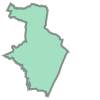

In [43]:
nome_cidade = 'Recife'

dados_municipios = municipios_pe.loc[municipios_pe['NM_MUN'] == nome_cidade]
gdf = gpd.GeoDataFrame(dados_municipios, geometry=dados_municipios['geometry'])
print(dados_municipios["NM_MUN"].iloc[0])
gdf['geometry'].iloc[0]

### Criação do shapefile do município

Cria-se o shapefile recortado do município e sua moldura, usado como referência para recortar os rasters e limitar a análise às áreas municipais.

In [44]:
zona_24s = "EPSG:31984"     # SIRGAS 2000 / UTM 24S
zona_25s = "EPSG:31985"     # SIRGAS 2000 / UTM 25S

sistema_coordenadas = zona_25s
cidade = nome_cidade.replace(" ", "-").lower()

gdf_reproj = gdf.to_crs(sistema_coordenadas)
gdf_reproj.to_file(f"outputs/limites_municipios/limite_{cidade}_reprojetado.shp")

In [45]:
shp = gpd.read_file(f"outputs/limites_municipios/limite_{cidade}_reprojetado.shp")

xmin, ymin, xmax, ymax = shp.total_bounds

# Adicionar padding
padding = 1000  # 1000m
xmin_pad, ymin_pad = xmin - padding, ymin - padding
xmax_pad, ymax_pad = xmax + padding, ymax + padding

res = 30

width = int((xmax_pad - xmin_pad) / res)
height = int((ymax_pad - ymin_pad) / res)

transform_raster = from_origin(xmin_pad, ymax_pad, res, res)

base_raster = np.zeros((height, width), dtype=np.uint8)

out_path = f"outputs/molduras_municipios/moldura-{cidade}.tif"
profile = {
    "driver": "GTiff",
    "dtype": "uint8",
    "count": 1,
    "width": width,
    "height": height,
    "crs": shp.crs,
    "transform": transform_raster
}

with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(base_raster, 1)

print("Raster de moldura criado")
print(f"Tamanho: {width}x{height}, Resolução: {res}, CRS: {shp.crs}")

Raster de moldura criado
Tamanho: 646x898, Resolução: 30, CRS: EPSG:31985


## Processamento do Modelo Digital de Elevação (MDE)

Carrega o **Modelo Digital de Elevação (MDE)** do município e realiza o pré-processamento necessário, como reprojeção e recorte para o limite municipal.  
Os dados foram obtidos na plataforma [NASA Earthdata Search](https://search.earthdata.nasa.gov/search/), utilizando o conjunto **ASTER Global Digital Elevation Model (GDEM) V003**, que fornece informações altimétrica, com resolução espacial de 30m.



In [46]:
mde_path = "dados/mde_pernambuco.tif"
moldura_path = f"outputs/molduras_municipios/moldura-{cidade}.tif"
output_path = f"outputs/mde/mde_{cidade}.tif"

# Pegar limites e dados do raster da moldura
with rasterio.open(moldura_path) as moldura:
    moldura_transform = moldura.transform
    moldura_width = moldura.width
    moldura_height = moldura.height
    moldura_crs = moldura.crs
    moldura_profile = moldura.profile

# Reprojetar e alinhar o MDE à moldura
with rasterio.open(mde_path) as src:
    profile = src.meta.copy()
    profile.update({
        "crs": moldura_crs,
        "transform": moldura_transform,
        "width": moldura_width,
        "height": moldura_height
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=moldura_transform,
                dst_crs=moldura_crs,
                resampling=Resampling.bilinear
            )

print(f"MDE alinhado e recortado salvo em: {output_path}")

MDE alinhado e recortado salvo em: outputs/mde/mde_recife.tif


## Processamento e Preparação dos Critérios de Análise

### Cálculo da Declividade

Gera a **declividade** a partir do MDE, importante para avaliação do risco de escoamento superficial.

In [47]:
mde_tratado_path = f"outputs/mde/mde_{cidade}.tif"

with rasterio.open(mde_tratado_path) as src:
    mde = src.read(1, masked=True)
    transform_raster = src.transform
    profile = src.profile

xres = transform_raster.a
yres = -transform_raster.e

gy, gx = np.gradient(mde, yres, xres)

slope = np.arctan(np.sqrt(gx**2 + gy**2))
slope_degrees = np.degrees(slope)

profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(f"outputs/declividade/declividade_{cidade}.tif", "w", **profile) as dst:
    dst.write(slope_degrees.astype(rasterio.float32), 1)

### Reclassificação da Declividade

Reclassifica a **declividade** em categorias de risco, facilitando a integração na análise multicritério.

In [48]:
with rasterio.open(f"outputs/declividade/declividade_{cidade}.tif") as src:
    slope = src.read(1)
    profile = src.profile

# Reclassificar
# Classes: 0-9 = 4, 9-23 = 3, 23-51 = 2, >51 = 1
reclass = np.zeros_like(slope, dtype=np.uint8)
reclass[(slope > 0) & (slope <= 9)] = 4
reclass[(slope > 9) & (slope <= 23)] = 3
reclass[(slope > 23) & (slope <= 51)] = 2
reclass[slope > 51] = 1

profile.update(dtype=rasterio.uint8, count=1)

with rasterio.open(f"outputs/declividade/declividade_{cidade}_reclass.tif", "w", **profile) as dst:
    dst.write(reclass, 1)

### Cálculo do Fluxo Acumulado

Calcula o **fluxo acumulado** utilizando ferramentas de hidrologia espacial do [GRASS GIS](https://grass.osgeo.org/download/), um software de código aberto especializado em geoprocessamento e modelagem espacial.  
O fluxo acumulado é usado para identificar áreas com maior propensão ao acúmulo de água, considerando a topografia e o escoamento superficial.


In [49]:
import os
import sys
import subprocess

# Caminho da instalação do GRASS
os.environ['GISBASE'] = r"C:\Program Files\GRASS GIS 8.4"
grass_base = os.environ['GISBASE']

# Adiciona ao PATH
os.environ['PATH'] += os.pathsep + os.path.join(grass_base, 'extrabin')
os.environ['PATH'] += os.pathsep + os.path.join(grass_base, 'bin')
os.environ['PATH'] += os.pathsep + os.path.join(grass_base, 'scripts')

# Adiciona bibliotecas do Python do GRASS
sys.path.append(os.path.join(grass_base, 'etc', 'python'))

import grass.script as gs
import grass.script.setup as gsetup

mde_tratado_path = f"outputs/mde/mde_{cidade}.tif"

grass_bin = r"C:\Program Files\GRASS GIS 8.4\grass84.bat"
gisdb = r"C:\grassdata"
location = cidade
mde_path = os.path.abspath(rf"outputs/mde/mde_{cidade}.tif")

# Criar a location se não existir
location_path = os.path.join(gisdb, location)
if not os.path.exists(location_path):
    subprocess.run([
        grass_bin,
        "-c", mde_path,
        location_path,
        "--exec", "exit"
    ], check=True)

# Inicializar sessão GRASS
mapset = "PERMANENT"
gsetup.init(gisdb, location, mapset)

mde_tratado_path = rf"outputs/mde/mde_{cidade}.tif"

gs.run_command("r.import", input=mde_tratado_path, output=f"mde_{cidade}", overwrite=True)

fluxo_acumulado_rast = f"fluxo_acumulado_{cidade}"

gs.run_command("r.watershed",
               elevation=f"mde_{cidade}",
               accumulation=fluxo_acumulado_rast,
               drainage=150,   # Tamanho mínimo da bacia em número de células
               overwrite=True)

fluxo_acumulado_path = rf"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}.tif"

gs.run_command("r.out.gdal",
               input=fluxo_acumulado_rast,
               output=fluxo_acumulado_path,
               format="GTiff",
               overwrite=True)

In [50]:
fluxo_acumulado_path = f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}.tif"

# Abrir raster
with rasterio.open(fluxo_acumulado_path) as src:
    fluxo = src.read(1)  # primeira banda
    profile = src.profile

# Mostrar algumas estatísticas
print("Shape:", fluxo.shape)
print("Min:", np.nanmin(fluxo))
print("Max:", np.nanmax(fluxo))
print("Mean:", np.nanmean(fluxo))

Shape: (898, 646)
Min: -192292.5461976719
Max: 39489.948031731365
Mean: -287.81561279929343


### Reclassificação do Fluxo Acumulado

Transforma os valores contínuos de **fluxo acumulado** em classes de risco compatíveis com os demais critérios.

In [51]:
with rasterio.open(f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}.tif") as src:
    flow_acc = src.read(1)
    profile = src.profile

# Reclassificar
reclass = np.zeros_like(flow_acc, dtype=np.uint8)
reclass[flow_acc <= 1600] = 1
reclass[(flow_acc >= 1601) & (flow_acc <= 5500)] = 2
reclass[(flow_acc >= 5501) & (flow_acc <= 18000)] = 3
reclass[flow_acc > 18000] = 4

profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=None  # Remove o valor de NoData inválido
)


with rasterio.open(
    f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}_reclass.tif", "w", **profile
) as dst:
    dst.write(reclass, 1)

### Uso do solo

Carrega e processa o raster de **uso do solo**, um critério importante que influencia diretamente a capacidade de infiltração do solo e, consequentemente, o risco de inundação.  
Os dados utilizados foram obtidos do [MapBiomas](https://brasil.mapbiomas.org/downloads/,  que fornece séries históricas anuais de uso e cobertura da terra no Brasi, para esta análise foram utilizados dados da Coleção 9.


In [52]:
uso_do_solo_pernambuco = "dados/uso-do-solo-pernambuco-2023.tif"
moldura_path = f"outputs/molduras_municipios/moldura-{cidade}.tif"
uso_alinhado = f"outputs/uso_do_solo/uso_do_solo_{cidade}.tif"

# Abrir moldura como referência
with rasterio.open(moldura_path) as moldura:
    moldura_transform = moldura.transform
    moldura_width = moldura.width
    moldura_height = moldura.height
    moldura_crs = moldura.crs

# Reprojetar uso do solo para a moldura
with rasterio.open(uso_do_solo_pernambuco) as src:
    profile = src.meta.copy()
    profile.update({
        "crs": moldura_crs,
        "transform": moldura_transform,
        "width": moldura_width,
        "height": moldura_height
    })

    with rasterio.open(uso_alinhado, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=moldura_transform,
                dst_crs=moldura_crs,
                resampling=Resampling.nearest
            )

print(f"Uso do solo alinhado e recortado salvo em: {uso_alinhado}")

Uso do solo alinhado e recortado salvo em: outputs/uso_do_solo/uso_do_solo_recife.tif


### Reclassificação do Uso do Solo

Reclassifica as categorias de **uso do solo** em classes de risco padronizadas, facilitando a integração com os demais critérios da análise multicritério.  
A legenda oficial para as classes do MapBiomas está disponível [neste documento](https://brasil.mapbiomas.org/wp-content/uploads/sites/4/2024/10/Legenda-Colecao-9-LEGEND-CODE_v2.pdf).


In [53]:
with rasterio.open(uso_alinhado) as src:
    uso = src.read(1)
    profile = src.profile

# Dicionário de reclassificação
reclass_dict = {
    # Vegetação nativa = 1
    1: 1, 3: 1, 4: 1, 5: 1, 6: 1, 49: 1,
    10: 1, 11: 1, 12: 1, 32: 1, 29: 1, 50: 1,

    # Regeneração / Florestas plantadas = 2
    9: 2,

    # Agricultura e pastagens = 3
    14: 3, 15: 3, 18: 3, 19: 3, 20: 3, 39: 3,
    40: 3, 41: 3, 36: 3, 46: 3, 47: 3, 48: 3,

    # Solo exposto e urbano = 4
    22: 4, 23: 4, 24: 4, 25: 4, 30: 4, 26: 4, 31: 4, 33: 4
}

reclass = np.zeros_like(uso, dtype=np.uint8)
for original, novo in reclass_dict.items():
    reclass[uso == original] = novo

profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=0
)

reclass_path = f"outputs/uso_do_solo/uso_do_solo_{cidade}_reclass.tif"
with rasterio.open(reclass_path, "w", **profile) as dst:
    dst.write(reclass, 1)

print(f"Uso do solo reclassificado salvo em: {reclass_path}")

Uso do solo reclassificado salvo em: outputs/uso_do_solo/uso_do_solo_recife_reclass.tif


### Verificação dos formatos dos arquivos gerados

Mostra algumas informações sobre os arquivos criados, a fim de conferir se todos os rasters possuem a mesma dimensão, resolução e sistema de coordenadas, garantindo consistência antes da análise multicritério.

In [54]:
rasters = {
    "MDE": f"outputs/mde/mde_{cidade}.tif",
    "Moldura": f"outputs/molduras_municipios/moldura-{cidade}.tif",
    "Declividade": f"outputs/declividade/declividade_{cidade}_reclass.tif",
    "Fluxo Acumulado": f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}_reclass.tif",
    "Uso do Solo": f"outputs/uso_do_solo/uso_do_solo_{cidade}_reclass.tif",
}

for nome, path in rasters.items():
    with rasterio.open(path) as src:
        print(f"{nome}:")
        print(f"Dimensões (linhas, colunas): {src.height}, {src.width}")
        print(f"Bounds (extensão): {src.bounds}")
        print(f"Resolução (pixel size): {src.res}")
        print(f"  Número de bandas: {src.count}")
        print(f"  CRS: {src.crs}")
        print(f"  Transform: {src.transform}")
        print()


MDE:
Dimensões (linhas, colunas): 898, 646
Bounds (extensão): BoundingBox(left=276747.7872667955, bottom=9097058.175284462, right=296127.7872667955, top=9123998.175284462)
Resolução (pixel size): (30.0, 30.0)
  Número de bandas: 1
  CRS: EPSG:31985
  Transform: | 30.00, 0.00, 276747.79|
| 0.00,-30.00, 9123998.18|
| 0.00, 0.00, 1.00|

Moldura:
Dimensões (linhas, colunas): 898, 646
Bounds (extensão): BoundingBox(left=276747.7872667955, bottom=9097058.175284462, right=296127.7872667955, top=9123998.175284462)
Resolução (pixel size): (30.0, 30.0)
  Número de bandas: 1
  CRS: EPSG:31985
  Transform: | 30.00, 0.00, 276747.79|
| 0.00,-30.00, 9123998.18|
| 0.00, 0.00, 1.00|

Declividade:
Dimensões (linhas, colunas): 898, 646
Bounds (extensão): BoundingBox(left=276747.7872667955, bottom=9097058.175284462, right=296127.7872667955, top=9123998.175284462)
Resolução (pixel size): (30.0, 30.0)
  Número de bandas: 1
  CRS: EPSG:31985
  Transform: | 30.00, 0.00, 276747.79|
| 0.00,-30.00, 9123998.18|
|

## Ponderação dos Critérios e Geração do Mapa de Risco

### Cálculo dos pesos via AHP

Define os pesos de cada critério usando o método AHP, garantindo consistência da matriz de comparação.

In [55]:
def pesos_metodo_ahp(pairwise):
    A = np.array(pairwise, dtype=float)
    # Autovetor principal
    vals, vecs = np.linalg.eig(A)
    idx = np.argmax(vals.real)
    w = vecs[:, idx].real
    w = w / w.sum()

    # Consistência
    n = A.shape[0]
    lambda_max = vals[idx].real
    CI = (lambda_max - n) / (n - 1)
    RI_table = {1:0.00, 2:0.00, 3:0.58, 4:0.90, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}
    RI = RI_table.get(n, 0.9)
    CR = CI / RI if RI > 0 else 0.0
    return w, CR

# Comparações (escala de Saaty)

# 1 - Mesma importância: os dois critérios contribuem igualmente para o objetivo.
# 3 - Importância pequena de um critério sobre o outro: experiência e julgamento favorecem levemente um critério em relação ao outro.
# 5 - Importância grande ou essencial: experiência e julgamento favorecem fortemente um critério em relação ao outro.
# 7 - Importância muito grande ou demonstrada: um critério é muito favorecido em relação ao outro; domínio demonstrado na prática.
# 9 - Importância absoluta: evidência favorece um critério em relação ao outro com o mais alto grau de certeza.
# Inversos - Se um critério recebe um valor em relação a outro, o inverso é usado na comparação oposta.
# Números racionais - Razões resultantes da escala; usados apenas para completar a matriz se necessário para consistência.

uso_vs_declividade = 3
uso_vs_fluxo = 1/3
declividade_vs_fluxo = 1/3

A = [
    [1, uso_vs_declividade, uso_vs_fluxo],
    [1/uso_vs_declividade, 1, declividade_vs_fluxo],
    [1/uso_vs_fluxo, 1/declividade_vs_fluxo, 1]
]

pesos, CR = pesos_metodo_ahp(A)
print(f"Pesos (Uso, Declividade, Fluxo): {np.round(pesos, 2)}")
print(f"Razão de consistência (RC): {CR:.2f}")


Pesos (Uso, Declividade, Fluxo): [0.28 0.14 0.58]
Razão de consistência (RC): 0.12


### Aplicação dos pesos e geração do mapa de risco

Combina os rasters reclassificados ponderados pelos pesos AHP para gerar o mapa final de risco de alagamento.

In [56]:
peso_uso, peso_declividade, peso_fluxo = pesos

print(f'Peso uso do solo: {peso_uso:.2f}')
print(f'Peso declividade: {peso_declividade:.2f}')
print(f'Peso fluxo acumulado: {peso_fluxo:.2f}')

Peso uso do solo: 0.28
Peso declividade: 0.14
Peso fluxo acumulado: 0.58


In [57]:
# Arquivos reclassificados
uso_do_solo_reclass = f"outputs/uso_do_solo/uso_do_solo_{cidade}_reclass.tif"
declividade_reclass = f"outputs/declividade/declividade_{cidade}_reclass.tif"
fluxo_acumulado_reclass = f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}_reclass.tif"
saida_risco = f"outputs/mapas_de_risco/risco_alagamento_{cidade}.tif"

with rasterio.open(uso_do_solo_reclass) as src1, \
     rasterio.open(declividade_reclass) as src2, \
     rasterio.open(fluxo_acumulado_reclass) as src3:

    uso = src1.read(1).astype(float)
    declividade = src2.read(1).astype(float)
    fluxo = src3.read(1).astype(float)

    perfil = src1.profile

# Aplicar pesos
risco = (uso * peso_uso) + (declividade * peso_declividade) + (fluxo * peso_fluxo)

perfil.update(dtype=rasterio.float32, count=1)
with rasterio.open(saida_risco, "w", **perfil) as dst:
    dst.write(risco.astype(rasterio.float32), 1)

print("Mapa de risco salvo em:", saida_risco)

Mapa de risco salvo em: outputs/mapas_de_risco/risco_alagamento_recife.tif


## Plotagem dos mapas

Visualização de todos os mapas criados durante o processo de análise.

In [58]:
def recortar_mapa(raster_path, output_path):
    shapefile_path = f"outputs/limites_municipios/limite_{cidade}_reprojetado.shp"
    
    gdf = gpd.read_file(shapefile_path)
    geometries = gdf.geometry.values

    with rasterio.open(raster_path) as src:
        dtype = src.dtypes[0]

        # Escolher valor de NoData dependendo do tipo do raster
        if np.issubdtype(dtype, np.integer):
            nodata = 0
        else:
            nodata = np.nan

        # Aplicar máscara e recorte
        out_image, out_transform = mask(
            src, geometries, crop=True, filled=True, nodata=nodata
        )

        if np.issubdtype(dtype, np.floating):
            out_image = out_image.astype("float32")

        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "dtype": out_image.dtype,
            "nodata": nodata
        })

    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(out_image)

    print(f"Raster recortado salvo em: {output_path}")


In [59]:
def plot_mapa(raster_path, titulo, colors="RdYlGn_r"):
    with rasterio.open(raster_path) as src:
        raster = np.ma.masked_invalid(src.read(1))
    
    plt.figure(figsize=(8,6))
    plt.title(titulo)
    img = plt.imshow(raster, cmap=colors, vmin=0, vmax=4)
    cbar = plt.colorbar(img, label="Índice de Risco")
    plt.axis("off")
    plt.show()

In [60]:
uso_do_solo_path = f"outputs/uso_do_solo/uso_do_solo_{cidade}_reclass.tif"
uso_do_solo_recortado_path = f"outputs/uso_do_solo/uso_do_solo_{cidade}_recortado.tif"

recortar_mapa(uso_do_solo_path, uso_do_solo_recortado_path)

Raster recortado salvo em: outputs/uso_do_solo/uso_do_solo_recife_recortado.tif


In [61]:
declividade_path = f"outputs/declividade/declividade_{cidade}_reclass.tif"
declividade_recortado_path = f"outputs/declividade/declividade_{cidade}_recortado.tif"

recortar_mapa(declividade_path, declividade_recortado_path)

Raster recortado salvo em: outputs/declividade/declividade_recife_recortado.tif


In [62]:
fluxo_acumulado_path = f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}_reclass.tif"
fluxo_acumulado_recortado_path = f"outputs/fluxo_acumulado/fluxo_acumulado_{cidade}_recortado.tif"

recortar_mapa(fluxo_acumulado_path, fluxo_acumulado_recortado_path)

Raster recortado salvo em: outputs/fluxo_acumulado/fluxo_acumulado_recife_recortado.tif


In [63]:
risco_path = f"outputs/mapas_de_risco/risco_alagamento_{cidade}.tif"
risco_recortado_path = f"outputs/mapas_de_risco/risco_alagamento_{cidade}_recortado.tif"

recortar_mapa(risco_path, risco_recortado_path)

Raster recortado salvo em: outputs/mapas_de_risco/risco_alagamento_recife_recortado.tif


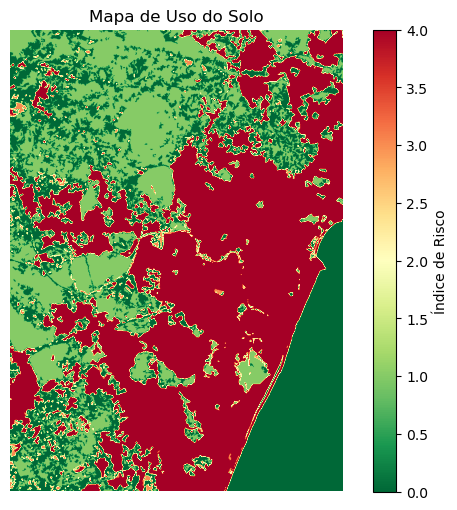

In [64]:
plot_mapa(uso_do_solo_path, f"Mapa de Uso do Solo")

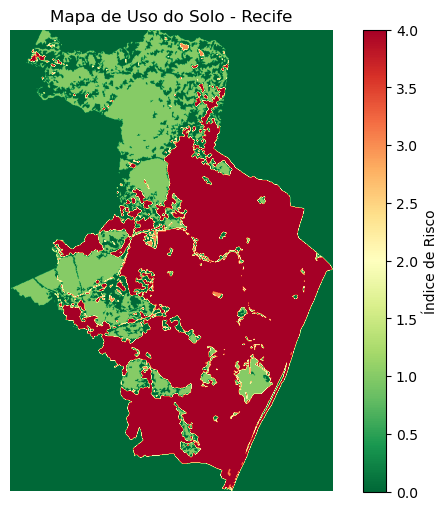

In [65]:
plot_mapa(uso_do_solo_recortado_path, f"Mapa de Uso do Solo - {nome_cidade.title()}")

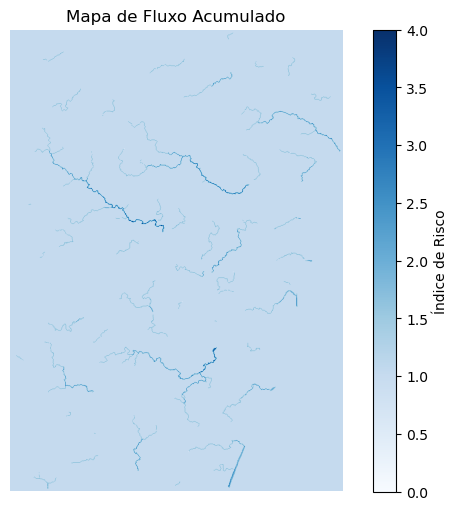

In [66]:
plot_mapa(fluxo_acumulado_path, f"Mapa de Fluxo Acumulado", colors="Blues")

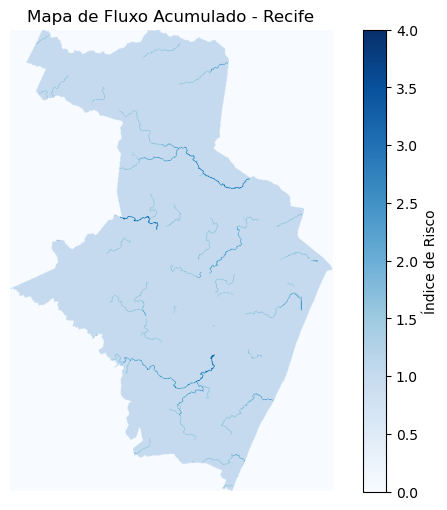

In [67]:
plot_mapa(fluxo_acumulado_recortado_path, f"Mapa de Fluxo Acumulado - {cidade.title()}", colors="Blues")

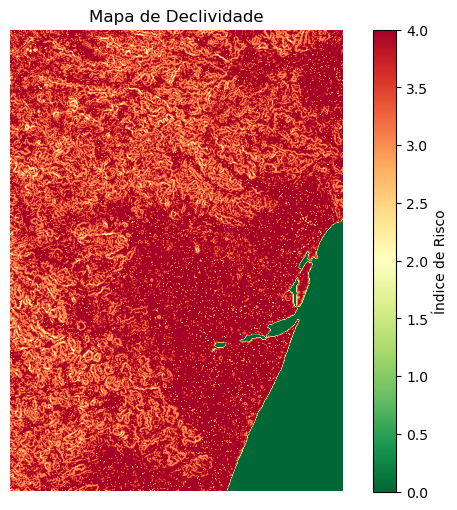

In [68]:
plot_mapa(declividade_path, f"Mapa de Declividade")

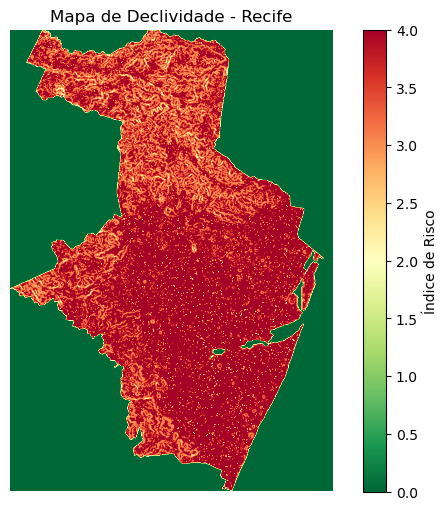

In [69]:
plot_mapa(declividade_recortado_path, f"Mapa de Declividade - {cidade.title()}")

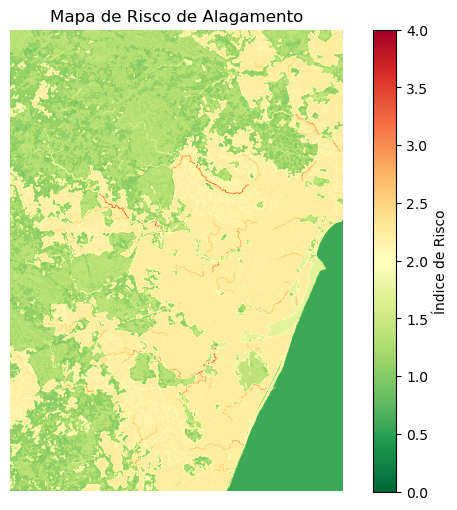

In [70]:
plot_mapa(risco_path, f"Mapa de Risco de Alagamento")

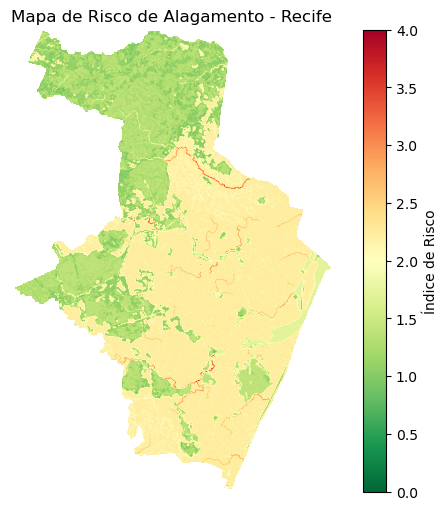

In [71]:
plot_mapa(risco_recortado_path, f"Mapa de Risco de Alagamento - {cidade.title()}")

## Identificação e plot da região mais afetada

Encontra o ponto de maior risco, converte para latitude/longitude, e gera um zoom da região mais crítica para análise detalhada.

Valor máximo: 4.0 em lat/lon: (-7.9895131458557795, -34.930348354600596)


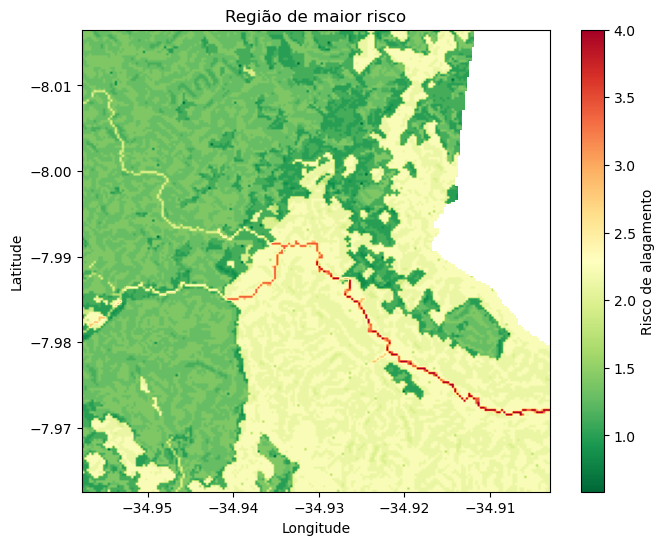

In [72]:
mapa_risco_municipio = f"outputs/mapas_de_risco/risco_alagamento_{cidade}_recortado.tif"

with rasterio.open(mapa_risco_municipio) as src:
    raster = src.read(1)
    transform_raster = src.transform
    nodata = src.nodata
    crs_raster = src.crs

raster = np.where(raster == nodata, np.nan, raster)

max_value = np.nanmax(raster)
max_pos = np.unravel_index(np.nanargmax(raster), raster.shape)
row, col = max_pos

# Coordenadas no CRS original (UTM)
x_utm, y_utm = rasterio.transform.xy(transform_raster, row, col)

# Transformar para EPSG:4326 (lat, lon)
lon, lat = transform(crs_raster, "EPSG:4326", [x_utm], [y_utm])
print(f"Valor máximo: {max_value} em lat/lon: ({lat[0]}, {lon[0]})")

# Dar zoom correto ao redor do ponto máximo
zoom_size = 100
row_start = max(row - zoom_size, 0)
row_end = min(row + zoom_size, raster.shape[0])
col_start = max(col - zoom_size, 0)
col_end = min(col + zoom_size, raster.shape[1])

raster_zoom = raster[row_start:row_end, col_start:col_end]

# extent correto
x_min, y_max = rasterio.transform.xy(transform_raster, row_start, col_start)
x_max, y_min = rasterio.transform.xy(transform_raster, row_end, col_end)

# Coordenadas do canto do recorte no CRS original
x_cantos = [x_min, x_max]
y_cantos = [y_min, y_max]

# Converter para EPSG:4326
lon_cantos, lat_cantos = transform(crs_raster, "EPSG:4326", x_cantos, y_cantos)

plt.figure(figsize=(8,6))
plt.imshow(
    raster_zoom,
    cmap="RdYlGn_r",
    extent=[lon_cantos[0], lon_cantos[1], lat_cantos[1], lat_cantos[0]]  # lat invertido
)
plt.colorbar(label="Risco de alagamento")
plt.title("Região de maior risco")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()